In [1]:
!pip install -q kaggle



In [2]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import classification_report
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, models
from sklearn.metrics import roc_curve

from sklearn.metrics import confusion_matrix, roc_auc_score

from tqdm.auto import tqdm

In [3]:
#фикс всех сидов
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(12345)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


Device: cpu


In [16]:
import kagglehub

path = kagglehub.dataset_download("aleemaparakatta/cats-and-dogs-mini-dataset")
print("Path to dataset files:", path)

print("Level 1:", os.listdir(path))

Using Colab cache for faster access to the 'cats-and-dogs-mini-dataset' dataset.
Path to dataset files: /kaggle/input/cats-and-dogs-mini-dataset
Level 1: ['dogs_set', 'cats_set']


In [17]:
DATASET_ROOT = path
print("DATASET_ROOT:", DATASET_ROOT)
print("Subdirs (classes):", os.listdir(DATASET_ROOT))

DATASET_ROOT: /kaggle/input/cats-and-dogs-mini-dataset
Subdirs (classes): ['dogs_set', 'cats_set']


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # меняю на небольшой размер чтобы быстрее учить
    transforms.ToTensor(), #преобразю картинку из формата PIL в np
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])

In [19]:
from torchvision import datasets

dataset = datasets.ImageFolder(root=DATASET_ROOT, transform=transform)



In [21]:
print("Классы:", dataset.classes)
print("Размер датасета:", len(dataset))


Классы: ['cats_set', 'dogs_set']
Размер датасета: 1000


In [22]:
total_size = len(dataset)
val_size = total_size // 10
test_size = total_size // 10
train_size = total_size - val_size - test_size

train_set, val_set, test_set = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(12345)
)

print("Train:", len(train_set))
print("Val:", len(val_set))
print("Test:", len(test_set))

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2)



Train: 800
Val: 100
Test: 100


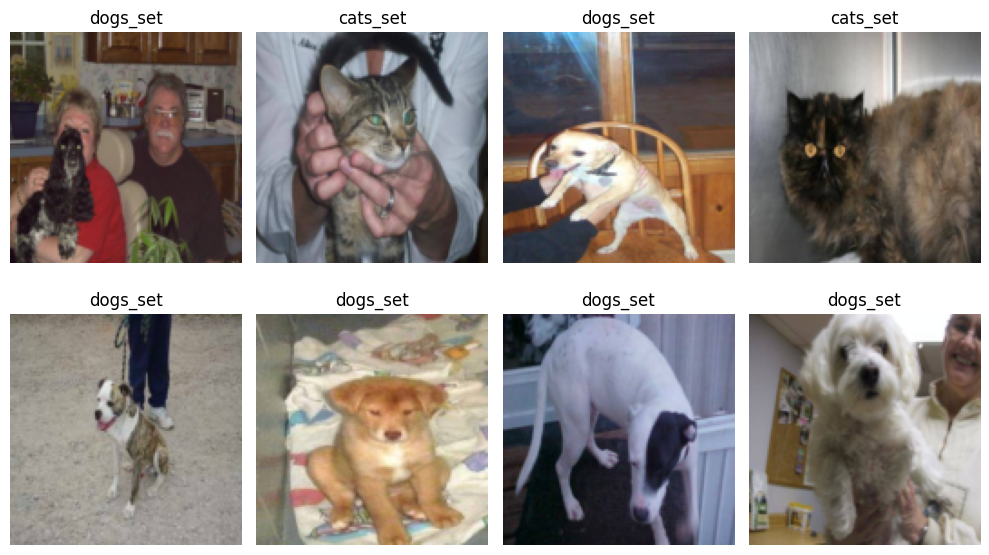

In [23]:
images, labels = next(iter(train_loader))

# перевоу обратно из norm
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

fig, axes = plt.subplots(2, 4, figsize=(10, 6))
axes = axes.flatten()

for img, label, ax in zip(images[:8], labels[:8], axes):
    img_np = img.permute(1, 2, 0).numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    ax.imshow(img_np)
    ax.set_title(dataset.classes[label.item()])
    ax.axis('off')

plt.tight_layout()
plt.show()


In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=3, model_name="model"):
    model = model.to(device)
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_losses = []

        for x, y in tqdm(train_loader, desc=f"[{model_name}] Epoch {epoch}/{num_epochs} - train", leave=False):
            x = x.to(device)
            y = y.to(device).float().unsqueeze(1)  # (B,) - (B,1) для BCEWithLogits

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # Валидация
        model.eval()
        val_losses = []
        correct = 0
        total = 0
        with torch.no_grad():
            for x_val, y_val in tqdm(val_loader, desc=f"[{model_name}] Epoch {epoch}/{num_epochs} - val", leave=False):
                x_val = x_val.to(device)
                y_val = y_val.to(device).float().unsqueeze(1)

                logits = model(x_val)
                loss = criterion(logits, y_val)
                val_losses.append(loss.item())

                probs = torch.sigmoid(logits)
                preds = (probs >= 0.5).long()
                correct += (preds == y_val.long()).sum().item()
                total += y_val.size(0)

        train_loss_mean = np.mean(train_losses)
        val_loss_mean   = np.mean(val_losses)
        val_acc         = correct / total

        history["train_loss"].append(train_loss_mean)
        history["val_loss"].append(val_loss_mean)
        history["val_acc"].append(val_acc)

        print(f"[{model_name}] Epoch {epoch}/{num_epochs} | "
              f"train_loss={train_loss_mean:.4f} | val_loss={val_loss_mean:.4f} | val_acc={val_acc:.4f}")

    return model, history


In [25]:
def evaluate_model(model, data_loader, device, model_name="model"):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
            labels = y.cpu().numpy()

            all_probs.extend(probs.tolist())
            all_labels.extend(labels.tolist())

    # Бинарные предсказания по порогу 0.5
    bin_preds = [1 if p >= 0.5 else 0 for p in all_probs]

    print(f"\n=== Отчёт для модели {model_name} ===")
    print(classification_report(all_labels, bin_preds, target_names=dataset.classes))

    cm = confusion_matrix(all_labels, bin_preds)
    print("Confusion matrix:\n", cm)

    # ROC-AUC
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = float('nan')

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC-кривая: {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return {
        "auc": auc,
        "report": classification_report(all_labels, bin_preds, target_names=dataset.classes, output_dict=True),
        "cm": cm,
    }


Возьму 3 модели :

ResNet18

VGG16

MobileNet v2

Для упрощения буду обучать только последний слой



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


[ResNet18] Epoch 1/5 - train:   0%|          | 0/25 [00:00<?, ?it/s]

[ResNet18] Epoch 1/5 - val:   0%|          | 0/4 [00:00<?, ?it/s]

[ResNet18] Epoch 1/5 | train_loss=0.5841 | val_loss=0.4591 | val_acc=0.8500


[ResNet18] Epoch 2/5 - train:   0%|          | 0/25 [00:00<?, ?it/s]

[ResNet18] Epoch 2/5 - val:   0%|          | 0/4 [00:00<?, ?it/s]

[ResNet18] Epoch 2/5 | train_loss=0.3485 | val_loss=0.3655 | val_acc=0.9000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^

[ResNet18] Epoch 3/5 - train:   0%|          | 0/25 [00:00<?, ?it/s]

^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[ResNet18] Epoch 3/5 - val:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>    
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      ^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^  ^  
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 ^^^^ ^  ^  ^^  ^ ^ ^ ^
  File "/us

[ResNet18] Epoch 3/5 | train_loss=0.3022 | val_loss=0.3493 | val_acc=0.9000


[ResNet18] Epoch 4/5 - train:   0%|          | 0/25 [00:00<?, ?it/s]

[ResNet18] Epoch 4/5 - val:   0%|          | 0/4 [00:00<?, ?it/s]

[ResNet18] Epoch 4/5 | train_loss=0.2830 | val_loss=0.4326 | val_acc=0.8800


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():
 
           ^^^^ ^^ ^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'^
  ^  ^ ^ ^

[ResNet18] Epoch 5/5 - train:   0%|          | 0/25 [00:00<?, ?it/s]

 ^ ^ ^ ^ ^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^^ ^  ^ ^ ^ ^  ^  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError^^: ^can only test a child process^^^
^^^^^^^^
AssertionError: can only test a child process


[ResNet18] Epoch 5/5 - val:   0%|          | 0/4 [00:00<?, ?it/s]

[ResNet18] Epoch 5/5 | train_loss=0.2637 | val_loss=0.3665 | val_acc=0.9000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():    if w.is_alive():
 
           ^ ^ ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3


=== Отчёт для модели ResNet18 ===
              precision    recall  f1-score   support

    cats_set       0.93      0.96      0.95        54
    dogs_set       0.95      0.91      0.93        46

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100

Confusion matrix:
 [[52  2]
 [ 4 42]]


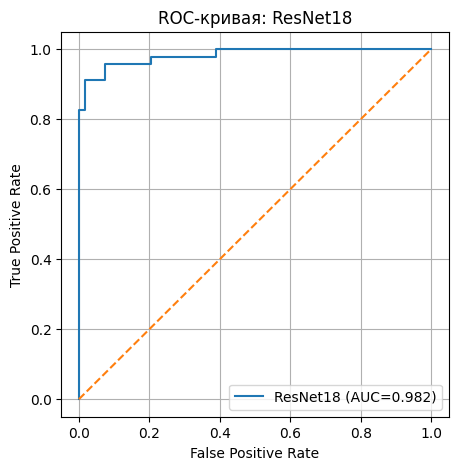

In [26]:
results = {}

#  ResNet18
resnet18_model = models.resnet18(pretrained=True)

# замораживаю все слои
for param in resnet18_model.parameters():
    param.requires_grad = False

# замен последний слой под бинарную классификацию
in_features = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(in_features, 1)

# обучаем только новый слой
for param in resnet18_model.fc.parameters():
    param.requires_grad = True

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(resnet18_model.fc.parameters(), lr=1e-3, momentum=0.9)

resnet18_model, resnet18_hist = train_model(
    resnet18_model, train_loader, val_loader,
    criterion, optimizer, device,
    num_epochs=5,
    model_name="ResNet18"
)

resnet18_metrics = evaluate_model(resnet18_model, test_loader, device, model_name="ResNet18")
results["ResNet18"] = {
    "history": resnet18_hist,
    "metrics": resnet18_metrics,
}


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 86.2MB/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>^
^Traceback (most recent call last):
^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.i

[VGG16] Epoch 1/3 - train:   0%|          | 0/25 [00:01<?, ?it/s]

if w.is_alive(): 
           ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  ^ ^ ^ ^ ^ ^ ^ ^ ^ ^^
^^AssertionError^^^: ^can only test a child process^
^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[VGG16] Epoch 1/3 - val:   0%|          | 0/4 [00:00<?, ?it/s]

[VGG16] Epoch 1/3 | train_loss=0.2167 | val_loss=0.0753 | val_acc=0.9600


[VGG16] Epoch 2/3 - train:   0%|          | 0/25 [00:00<?, ?it/s]

[VGG16] Epoch 2/3 - val:   0%|          | 0/4 [00:00<?, ?it/s]

[VGG16] Epoch 2/3 | train_loss=0.0842 | val_loss=0.0990 | val_acc=0.9600


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():
 if w.is_alive():
            ^ 

[VGG16] Epoch 3/3 - train:   0%|          | 0/25 [00:00<?, ?it/s]

^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'    
assert self._parent_pid == os.getpid(), 'can only test a child process' 
              ^ ^  ^^  ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^AssertionError^: 
AssertionErrorcan only test a child process
: can only test a child process


[VGG16] Epoch 3/3 - val:   0%|          | 0/4 [00:00<?, ?it/s]

[VGG16] Epoch 3/3 | train_loss=0.0775 | val_loss=0.1147 | val_acc=0.9600

=== Отчёт для модели VGG16 ===
              precision    recall  f1-score   support

    cats_set       1.00      1.00      1.00        54
    dogs_set       1.00      1.00      1.00        46

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Confusion matrix:
 [[54  0]
 [ 0 46]]


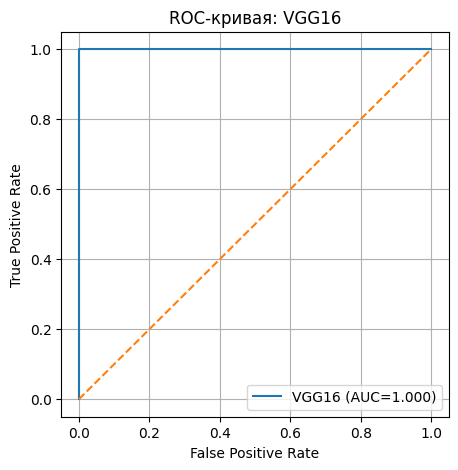

In [27]:
#VGG16
vgg16_model = models.vgg16(pretrained=True)

for param in vgg16_model.parameters():
    param.requires_grad = False

# последний слой в classifier
in_features = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Linear(in_features, 1)

for param in vgg16_model.classifier[6].parameters():
    param.requires_grad = True

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(vgg16_model.classifier[6].parameters(), lr=1e-3, momentum=0.9)

vgg16_model, vgg16_hist = train_model(
    vgg16_model, train_loader, val_loader,
    criterion, optimizer, device,
    num_epochs=3,
    model_name="VGG16"
)

vgg16_metrics = evaluate_model(vgg16_model, test_loader, device, model_name="VGG16")
results["VGG16"] = {
    "history": vgg16_hist,
    "metrics": vgg16_metrics,
}


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 120MB/s]


[MobileNetV2] Epoch 1/3 - train:   0%|          | 0/25 [00:00<?, ?it/s]

[MobileNetV2] Epoch 1/3 - val:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[MobileNetV2] Epoch 1/3 | train_loss=0.6051 | val_loss=0.3855 | val_acc=0.8600


[MobileNetV2] Epoch 2/3 - train:   0%|          | 0/25 [00:00<?, ?it/s]

[MobileNetV2] Epoch 2/3 - val:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>^
^^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^  ^^ ^ ^^

[MobileNetV2] Epoch 2/3 | train_loss=0.3599 | val_loss=0.3298 | val_acc=0.8600


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>
    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive():
        ^ ^ ^^ ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ 
   File "/usr/lib/pyth

[MobileNetV2] Epoch 3/3 - train:   0%|          | 0/25 [00:01<?, ?it/s]

^ ^ ^^  ^ ^ ^ ^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  ^ ^ ^ ^    ^ ^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError^: can only test a child process^
^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[MobileNetV2] Epoch 3/3 - val:   0%|          | 0/4 [00:00<?, ?it/s]

[MobileNetV2] Epoch 3/3 | train_loss=0.3074 | val_loss=0.3001 | val_acc=0.8900


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7c737e9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():

            ^ ^ ^^^^^^^^^^^^^^^^^^^^^
^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._par


=== Отчёт для модели MobileNetV2 ===
              precision    recall  f1-score   support

    cats_set       1.00      0.83      0.91        54
    dogs_set       0.84      1.00      0.91        46

    accuracy                           0.91       100
   macro avg       0.92      0.92      0.91       100
weighted avg       0.92      0.91      0.91       100

Confusion matrix:
 [[45  9]
 [ 0 46]]


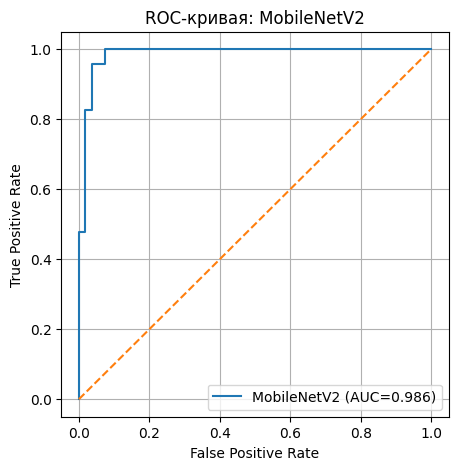

In [28]:
#  MobileNet v2
mobilenet_model = models.mobilenet_v2(pretrained=True)

for param in mobilenet_model.parameters():
    param.requires_grad = False

in_features = mobilenet_model.classifier[1].in_features
mobilenet_model.classifier[1] = nn.Linear(in_features, 1)

for param in mobilenet_model.classifier[1].parameters():
    param.requires_grad = True

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(mobilenet_model.classifier[1].parameters(), lr=1e-3, momentum=0.9)

mobilenet_model, mobilenet_hist = train_model(
    mobilenet_model, train_loader, val_loader,
    criterion, optimizer, device,
    num_epochs=3,
    model_name="MobileNetV2"
)

mobilenet_metrics = evaluate_model(mobilenet_model, test_loader, device, model_name="MobileNetV2")
results["MobileNetV2"] = {
    "history": mobilenet_hist,
    "metrics": mobilenet_metrics,
}


In [30]:
import pandas as pd

In [31]:
rows = []
for name, info in results.items():
    auc = info["metrics"]["auc"]
    # посленяя точнось с валидации
    val_acc = info["history"]["val_acc"][-1]
    rows.append({
        "model": name,
        "val_acc_last_epoch": val_acc,
        "test_auc": auc,
    })

df_results = pd.DataFrame(rows)
df_results


,model,val_acc_last_epoch,test_auc
0,ResNet18,0.90,0.982287
1,VGG16,0.96,1.000000
2,MobileNetV2,0.89,0.985507


Все три модели на ImageNet показали высокое качество, но лучше всего себя показаа VGG16, дав идеальные метрики на тесте где accuracy и f1 = 100 точности для обоих классов. ResNet18 показал немного более скромный, но все же хороший результат с accuracy около 94 процентов и достаточно сбалансированными precision/recall для обоих классов, а MobileNetV2 оказался чуть слабее при accuracy около 91 процента (модель хорошо распознаёт собак recall 100%, но чаще ошибается на котах recall = 83 %), что может быть связано с её архитектурой и меньшей емкостью по сравнению с VGG16 и ResNet18
